In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import display, Math

In [15]:
# Tensor Factor Model with Linear Time Dependency
latex_tensor_factor_model = r'''

Y_{tnd} = \sum_{r} \beta(t) u_{t}^{(r)} v_{n}^{(r)} w_{d}^{(r)} + \epsilon_{tnd}

'''

# Latent Factor Model with Linear Time Dependency
latex_latent_factor_model = r'''

Y_{tnd} = \beta(t)(u_{t} + v_{n}) + \epsilon_{tnd}

'''

display(Math(latex_tensor_factor_model))
display(Math(latex_latent_factor_model))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:


class TensorFactorModel(keras.Model):
    '''
    The TensorFactorModel class represents the tensor factor model with a linear time dependency. 
    It has three dense layers (ut, vn, and wd) that transform the input. 
    The beta parameter controls the time dependency, and the model calculates the predicted outcome based on the product of ut, vn, and wd with the corresponding coefficients. 
    The model sums these products along the last dimension and adds random noise epsilon to the potential outcomes.
    Specifically, the the beta parameter is multiplied with the time index t to create a time-dependent coefficient. This coefficient is used in the calculations of the latent factors 
    in both the TensorFactorModel and LatentFactorModel
    '''
    def __init__(self, r, beta):
        super(TensorFactorModel, self).__init__()
        self.ut = keras.layers.Dense(r, activation='linear')
        self.vn = keras.layers.Dense(r, activation='linear')
        self.wd = keras.layers.Dense(r, activation='linear')
        self.beta = int(beta)

    def call(self, inputs):
        t, n, d = inputs
        time = self.beta * t[:, tf.newaxis]
        ut = self.ut(time)
        vn = self.vn(n[:, tf.newaxis])
        wd = self.wd(d[:, tf.newaxis])
        return tf.reduce_sum(ut * vn * wd, axis=-1)

class LatentFactorModel(keras.Model):
    '''
     The LatentFactorModel class represents the latent factor model with a linear time dependency. 
     It has two dense layers (ut and vn) that transform the input. 
     The beta parameter controls the time dependency, and the model calculates the predicted outcome based on the sum of ut and vn multiplied by the corresponding coefficient beta. 
     The model adds random noise epsilon to the potential outcomes.
    '''
    def __init__(self, r, beta):
        super(LatentFactorModel, self).__init__()
        self.ut = keras.layers.Dense(r, activation='linear')
        self.vn = keras.layers.Dense(r, activation='linear')
        self.beta = int(beta)

    def call(self, inputs):
        t, n, d = inputs
        time = self.beta * t[:, tf.newaxis]
        ut = self.ut(time)
        vn = self.vn(n[:, tf.newaxis])
        return ut + vn

# Set the dimensions
T = 50
N = 100
D = 3
r = 2

# Set the time dependency coefficient
beta = 5.1

# Create the models
tensor_factor_model = TensorFactorModel(r, beta)
latent_factor_model = LatentFactorModel(r, beta)

# Generate potential outcomes
Y = tensor_factor_model.predict([
    np.tile(np.arange(T), N * D).reshape(N * D, T),
    np.repeat(np.arange(N), D * T).reshape(N * D, T),
    np.tile(np.arange(D), N * T).reshape(N * D, T)
])
epsilon = np.random.randn(N * D, T)
potential_outcomes = latent_factor_model.predict([
    np.tile(np.arange(T), N * D).reshape(N * D, T),
    np.repeat(np.arange(N), D * T).reshape(N * D, T),
    np.tile(np.arange(D), N * T).reshape(N * D, T)
]) + np.expand_dims(epsilon, axis=-1)

# Compute target causal parameter
target_parameter = np.mean(potential_outcomes, axis=-1)

print("Target Causal Parameter:")
print(target_parameter)


Target Causal Parameter:
[[-193.1576095  -190.71658492 -192.74475083 ... -192.09555491
  -191.6397462  -194.23548833]
 [-191.12122767 -191.55602251 -190.81231852 ... -194.04277278
  -191.988627   -193.80413343]
 [-193.64705544 -193.02649222 -193.14732309 ... -191.78933164
  -192.02341859 -193.56399399]
 ...
 [ -52.86453864  -51.58169229  -53.70222093 ...  -51.70448633
   -51.56780919  -53.02909389]
 [ -53.22016797  -52.38752808  -54.5801592  ...  -53.52704263
   -52.06487446  -50.98110906]
 [ -53.55428112  -50.87528156  -51.82869351 ...  -51.71106864
   -51.47513829  -51.44118495]]


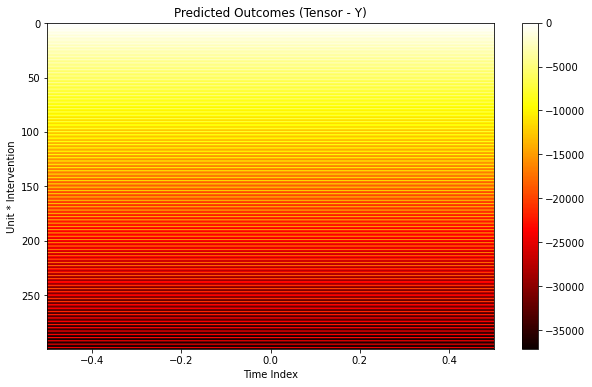

In [21]:
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(Y, cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Predicted Outcomes (Tensor - Y)')
plt.xlabel('Time Index')
plt.ylabel('Unit * Intervention')
plt.show()


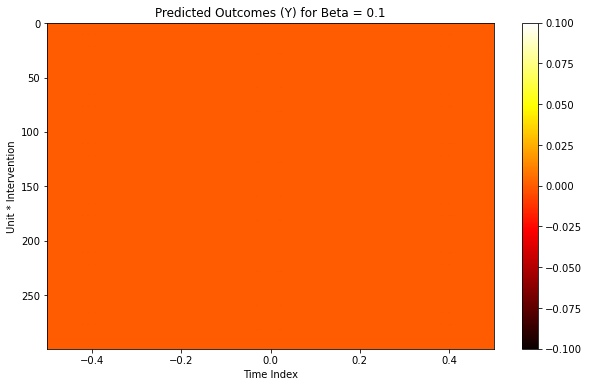

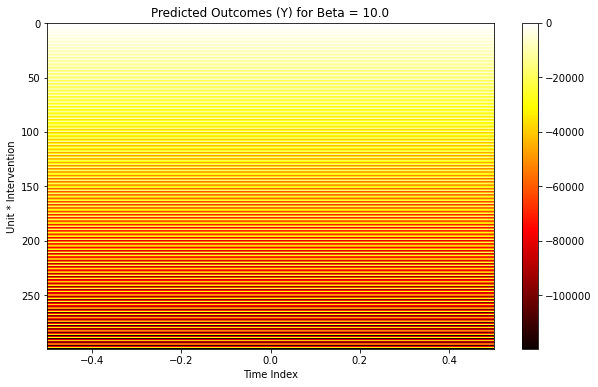

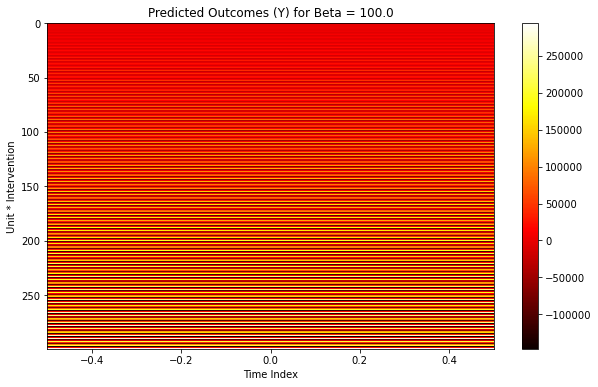

In [22]:
import matplotlib.pyplot as plt

# Set the dimensions
T = 50
N = 100
D = 3
r = 2

# Set the extreme values of beta
beta_values = [0.1, 10.0, 100.0]

# Generate potential outcomes and visualize Y for each beta value
for beta in beta_values:
    # Create the models
    tensor_factor_model = TensorFactorModel(r, beta)
    latent_factor_model = LatentFactorModel(r, beta)

    # Generate potential outcomes
    Y = tensor_factor_model.predict([
        np.tile(np.arange(T), N * D).reshape(N * D, T),
        np.repeat(np.arange(N), D * T).reshape(N * D, T),
        np.tile(np.arange(D), N * T).reshape(N * D, T)
    ])
    
    # Plot the heatmap of Y
    plt.figure(figsize=(10, 6))
    plt.imshow(Y, cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title(f'Predicted Outcomes (Y) for Beta = {beta}')
    plt.xlabel('Time Index')
    plt.ylabel('Unit * Intervention')
    plt.show()


In [23]:
'''The differences in the predicted outcomes based on the strength of the time dependency captured by beta.
Higher values of beta will result in more pronounced time-dependent effects in the predicted outcomes.
'''

'The differences in the predicted outcomes based on the strength of the time dependency captured by beta.\nHigher values of beta will result in more pronounced time-dependent effects in the predicted outcomes.\n'

# Latent Factor Model

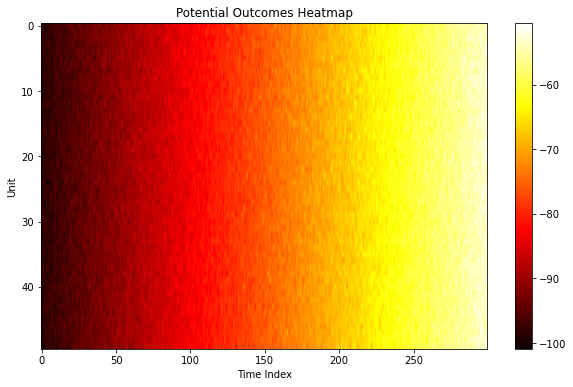

In [5]:
import matplotlib.pyplot as plt

# Heatmap
plt.figure(figsize=(10, 6))
potential_outcomes_reshaped = potential_outcomes.transpose(1, 0, 2)
plt.imshow(potential_outcomes_reshaped[:,:,0], cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Potential Outcomes Heatmap')
plt.xlabel('Time Index')
plt.ylabel('Unit')
plt.show()



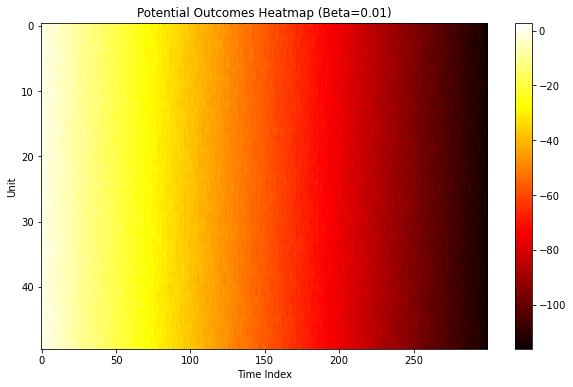

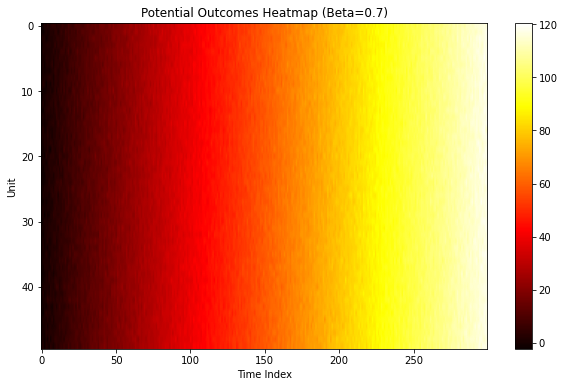

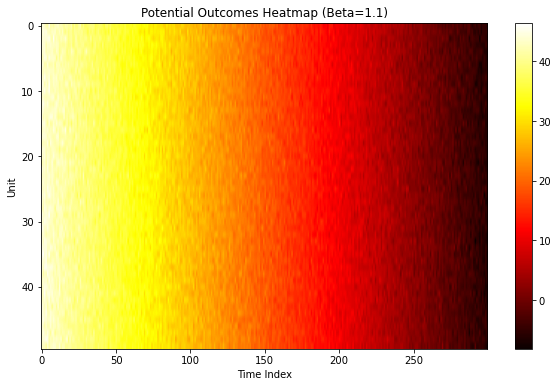

In [9]:
import matplotlib.pyplot as plt

# Define the values of beta for three permutations
betas = [0.01, 0.7, 1.1]

# Loop over the betas and generate the heatmaps
for i, beta in enumerate(betas):
    # Create the models with the current beta
    tensor_factor_model = TensorFactorModel(r, beta)
    latent_factor_model = LatentFactorModel(r, beta)

    # Generate potential outcomes
    Y = tensor_factor_model.predict([
        np.tile(np.arange(T), N * D).reshape(N * D, T),
        np.repeat(np.arange(N), D * T).reshape(N * D, T),
        np.tile(np.arange(D), N * T).reshape(N * D, T)
    ])
    epsilon = np.random.randn(N * D, T)
    potential_outcomes = latent_factor_model.predict([
        np.tile(np.arange(T), N * D).reshape(N * D, T),
        np.repeat(np.arange(N), D * T).reshape(N * D, T),
        np.tile(np.arange(D), N * T).reshape(N * D, T)
    ]) + np.expand_dims(epsilon, axis=-1)

    # Reshape potential outcomes for plotting
    potential_outcomes_reshaped = potential_outcomes.transpose(1, 0, 2)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(potential_outcomes_reshaped[:, :, 0], cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title(f'Potential Outcomes Heatmap (Beta={beta})')
    plt.xlabel('Time Index')
    plt.ylabel('Unit')
    plt.show()


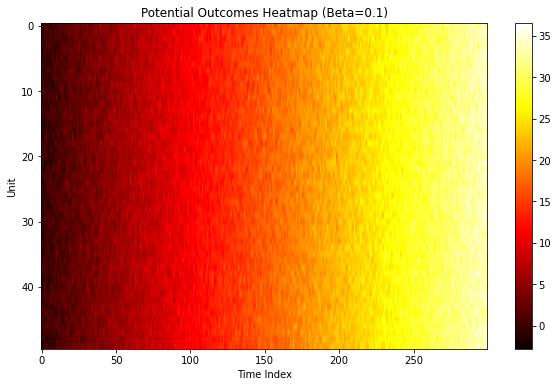

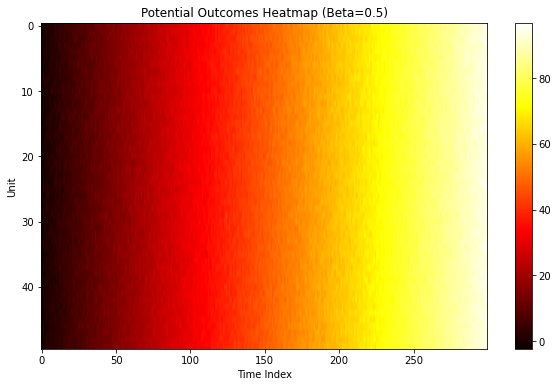

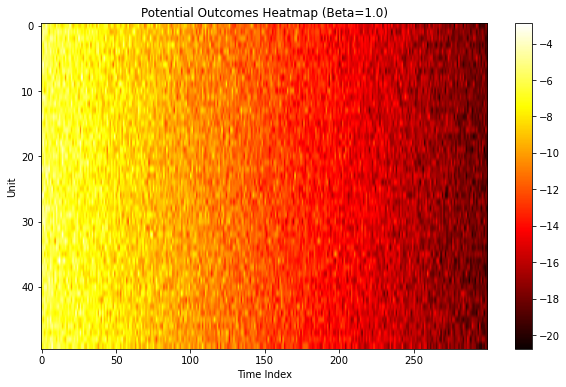

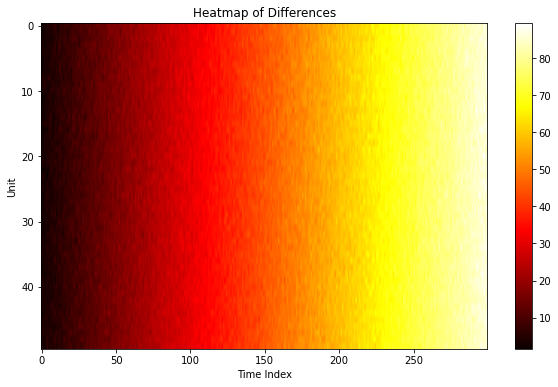

In [11]:
import matplotlib.pyplot as plt

# Define the values of beta for three permutations
betas = [0.1, 0.5, 1.0]

# Initialize an empty array to store the differences
diff_heatmap = []

# Loop over the betas and generate the heatmaps
for i, beta in enumerate(betas):
    # Create the models with the current beta
    tensor_factor_model = TensorFactorModel(r, beta)
    latent_factor_model = LatentFactorModel(r, beta)

    # Generate potential outcomes
    Y = tensor_factor_model.predict([
        np.tile(np.arange(T), N * D).reshape(N * D, T),
        np.repeat(np.arange(N), D * T).reshape(N * D, T),
        np.tile(np.arange(D), N * T).reshape(N * D, T)
    ])
    epsilon = np.random.randn(N * D, T)
    potential_outcomes = latent_factor_model.predict([
        np.tile(np.arange(T), N * D).reshape(N * D, T),
        np.repeat(np.arange(N), D * T).reshape(N * D, T),
        np.tile(np.arange(D), N * T).reshape(N * D, T)
    ]) + np.expand_dims(epsilon, axis=-1)

    # Reshape potential outcomes for plotting
    potential_outcomes_reshaped = potential_outcomes.transpose(1, 0, 2)

    # Store the differences between potential outcomes
    if i > 0:
        diff_heatmap.append(np.abs(potential_outcomes_reshaped[:, :, 0] - prev_potential_outcomes))

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(potential_outcomes_reshaped[:, :, 0], cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title(f'Potential Outcomes Heatmap (Beta={beta})')
    plt.xlabel('Time Index')
    plt.ylabel('Unit')
    plt.show()

    # Store the current potential outcomes for the next iteration
    prev_potential_outcomes = potential_outcomes_reshaped[:, :, 0]

# Calculate the mean difference heatmap
mean_diff_heatmap = np.mean(diff_heatmap, axis=0)

# Plot the heatmap of differences
plt.figure(figsize=(10, 6))
plt.imshow(mean_diff_heatmap, cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Heatmap of Differences')
plt.xlabel('Time Index')
plt.ylabel('Unit')
plt.show()
